# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information our of natural language (could be text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4acbe7ff-dbbc-e82b-efce-d768590eafbd)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-04-18 15:59:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-18 15:59:36 (84.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-04-18 15:59:41--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 173.194.198.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-04-18 15:59:41 (103 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [4]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training samples
import random
random_index = random.randint(0, len(train_df) - 5) # create random indexes

for row in train_df_shuffled[["text", "target"]][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "not real disaster")
  print(f"Text:\n{text}\n")
  print()

Target: 0 not real disaster
Text:
@Sweet2Young I came in! Had he fucking moved his entire existence would've been obliterated.


Target: 0 not real disaster
Text:
Businesses are deluged with invoices. Make yours stand ogt with colomr or shape and it's likely to rise to the top of the pay' pile.


Target: 1 (real disaster)
Text:
Police Monitoring 200 Jihadis in Poland http://t.co/1wCOfmLUb9 via @freedomoutpost


Target: 0 not real disaster
Text:
KS except every character is Shizune.
The world would explode.


Target: 0 not real disaster
Text:
China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/3PBFyJx0yA




### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                  train_df_shuffled["target"].to_numpy(), 
                                                  test_size=0.1,
                                                  random_state=42)

In [11]:
# Check the lenghts
len(X_train), len(X_val), len(y_train), len(y_val)

(6851, 762, 6851, 762)

In [12]:
# Check the first 10 samples
X_train[:10], y_train[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character)
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [13]:
X_train

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # defines how many words are in our vocabulary (automatucally adds <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be
                                    pad_to_max_tokens=False # pad shorter sequences with zeros
                                    )

In [15]:
# Find the average number of tokens (words) in the training tweets
import numpy as np

np.round(np.sum([len(i.split()) for i in X_train]) / len(X_train))

15.0

In [16]:
# Setup text vectorization variables
max_vocab_length = 10000 #max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet can our model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the train data
text_vectorizer.adapt(X_train)

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
       \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP INST APCH. RWY 05. CURFEW IN OPER UNTIL 2030 Z. TAXIWAYS FOXTROT 5 &amp; FOXTROT 6 NAVBL. TMP: 10.       

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1077,  236, 3243, 6380, 5974, 8725,    1, 2119, 3739, 4138, 3451,
         912,  378,    4, 3561]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Num of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")


Num of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding we' re going to use a TensorFlow Embedding layer.

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example a value of 100 would mean token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [21]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

embedding

In [22]:
# Get a random sentence from the training set
random_sentence = random.choice(X_train)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @Barbi_Twins We need help-horses will die! Please RT &amp; sign petition! Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03046485, -0.02184856,  0.01479446, ...,  0.02076318,
         -0.01784549, -0.03682669],
        [-0.01773689, -0.02007257, -0.02507737, ...,  0.04585961,
         -0.0083668 , -0.04530063],
        [ 0.0463346 , -0.02508965, -0.02483626, ..., -0.00606247,
          0.02580762,  0.01047617],
        ...,
        [-0.00845444,  0.00025467,  0.01310524, ..., -0.04396046,
          0.04629603,  0.0383859 ],
        [ 0.03005694, -0.02804085, -0.03888053, ..., -0.04506729,
         -0.04356626, -0.00649581],
        [ 0.04424386, -0.02034291, -0.03552591, ...,  0.01124201,
         -0.01315133,  0.04705944]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03046485, -0.02184856,  0.01479446, -0.02837266,  0.00919526,
         0.01513222,  0.04725546,  0.00701779, -0.03523855,  0.01933063,
        -0.02667916,  0.01844014,  0.00611196,  0.01700044,  0.01255527,
        -0.00892622,  0.02732034,  0.04704607,  0.00091117,  0.03124486,
         0.01079648,  0.03732142,  0.00899469, -0.03215279, -0.02900171,
         0.02311555,  0.02324561,  0.0161472 ,  0.04547825, -0.03028754,
         0.030418  ,  0.03682841,  0.03214866,  0.01432345, -0.02360752,
         0.02566712, -0.03625793,  0.04829307,  0.01005618,  0.0134587 ,
        -0.01567841,  0.02067891, -0.02571993,  0.02536033,  0.0276514 ,
         0.00273547, -0.03220282, -0.00420487, -0.02645062, -0.04398079,
        -0.04889441, -0.01106922, -0.01199985, -0.02813389, -0.04196167,
        -0.00099244,  0.02917923,  0.02386076,  0.04158903, -0.04998818,
        -0.02793992,  0.0232248 ,  0.03800137,  0.02540204,  0.01165824,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

We'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

IT's common practice to use non-DL algorithms as a baseline because of their speed and then using DL to see if you can improve upon them.

In [24]:
# Create Naive Bayes model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate our baseline model
baseline_score = model_0.score(X_val, y_val)

In [26]:
baseline_score

0.7926509186351706

In [27]:
# Make predictions
baseline_preds = model_0.predict(X_val)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create a function to output some classification evaluation metrics
def eval_metrics(y_true, y_pred):
  """
  Calculates accuracy, precision, recall and f1-score.

  Args:
    model: a ML model to make predictions on
    X_test: a tensor of test features
    y_test: a tensor of test labels
  
  Returns:
    a dict with all keys of all mentioned above metrics
    with values of those metrics
  """
  results = {}


  accuracy = accuracy_score(y_true=y_true,  
                            y_pred=y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true=y_true,
                                                             y_pred = y_pred,
                                                             average="weighted")
  
  results["accuracy"] = accuracy
  results["precision"] = precision
  results["recall"] = recall
  results["f1"] = f1

  return results

In [29]:
# Check the evaluation metrics
baseline_results = eval_metrics(y_true=y_val,
                                y_pred=baseline_preds)

baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [30]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [31]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# Fit the model
model_1_history = model_1.fit(x=X_train,
                              y=y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230418-155951
Epoch 1/5
215/215 [==============================] - 25s 78ms/step - loss: 0.6097 - accuracy: 0.6946 - val_loss: 0.5349 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4411 - accuracy: 0.8183 - val_loss: 0.4710 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3462 - accuracy: 0.8594 - val_loss: 0.4571 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2841 - accuracy: 0.8911 - val_loss: 0.4617 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2386 - accuracy: 0.9124 - val_loss: 0.4868 - val_accuracy: 0.7913


In [35]:
# Check the results
model_1.evaluate(X_val, y_val)

24/24 [==============================] - 0s 4ms/step - loss: 0.4868 - accuracy: 0.7913


[0.4868391454219818, 0.7913385629653931]

In [36]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(X_val)
model_1_pred_probs

24/24 [==============================] - 0s 3ms/step


array([[2.89558738e-01],
       [8.08632314e-01],
       [9.97997463e-01],
       [1.19977489e-01],
       [1.30055383e-01],
       [9.23173904e-01],
       [8.99789333e-01],
       [9.92929757e-01],
       [9.51633215e-01],
       [2.74725288e-01],
       [9.30701196e-02],
       [6.41045988e-01],
       [3.27208750e-02],
       [1.77761599e-01],
       [4.71873628e-03],
       [1.12534329e-01],
       [2.12809499e-02],
       [6.63878769e-02],
       [2.07240507e-01],
       [4.46313173e-01],
       [9.07224238e-01],
       [3.38038877e-02],
       [4.14915979e-01],
       [6.73786849e-02],
       [9.56109345e-01],
       [9.98937428e-01],
       [3.76200527e-02],
       [5.16852066e-02],
       [1.87303368e-02],
       [2.02919587e-01],
       [4.80271161e-01],
       [2.60711163e-01],
       [4.47683632e-01],
       [1.92828909e-01],
       [4.21639442e-01],
       [5.58903217e-02],
       [9.94377434e-01],
       [1.50388360e-01],
       [3.13855819e-02],
       [9.97792840e-01],


In [37]:
# Convert model prediction probabiliites to label format
model_1_pred_probs.shape

(762, 1)

In [38]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds.shape

TensorShape([762])

In [39]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [40]:
# Calculate our model_1 results
model_1_results = eval_metrics(y_true=y_val,
                               y_pred=model_1_preds)

model_1_results

{'accuracy': 0.7913385826771654,
 'precision': 0.7997458316766562,
 'recall': 0.7913385826771654,
 'f1': 0.7874035967950923}

## Visualizing learned embeddings

In [41]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [42]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in out training data which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()
embed_weights[0].shape

(10000, 128)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize iter
To do so, TensorFlow has a handy tool called projector.

In [45]:
# Create embedding files (from tf's word embedding documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue # skip, 0 it's padding
  
  vec = embed_weights[0][index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")

out_v.close()
out_m.close()

In [46]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent neural networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.



### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [47]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x) # when you are stacking RNN cells together, you need to set return_sequences=True
# x = layers.Dropout(0.5)(x)
x = layers.LSTM(64)(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(64, activation="relu", kernel_regularizer="l2")(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [49]:
# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20230418-160112
Epoch 1/5
215/215 [==============================] - 28s 93ms/step - loss: 0.2132 - accuracy: 0.9240 - val_loss: 0.5623 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1540 - accuracy: 0.9421 - val_loss: 0.6425 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1263 - accuracy: 0.9517 - val_loss: 0.7096 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1060 - accuracy: 0.9610 - val_loss: 0.6824 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0806 - accuracy: 0.9695 - val_loss: 1.1183 - val_accuracy: 0.7717


In [51]:
# Make predictions
model_2_pred_probs = model_2.predict(X_val)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[6.3750800e-04],
       [6.8386859e-01],
       [9.9956626e-01],
       [7.3729023e-02],
       [1.7093160e-04],
       [9.9350739e-01],
       [7.9359794e-01],
       [9.9975497e-01],
       [9.9937636e-01],
       [4.3293685e-01]], dtype=float32)

In [52]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = eval_metrics(y_true=y_val,
                               y_pred=model_2_preds)

model_2_results

{'accuracy': 0.7716535433070866,
 'precision': 0.7767213938683196,
 'recall': 0.7716535433070866,
 'f1': 0.7681214344851189}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell, but has less parameters.

In [54]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need to return_sequences=True
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [55]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                       

In [56]:
# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Fit the model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230418-160159
Epoch 1/5
215/215 [==============================] - 15s 52ms/step - loss: 0.1475 - accuracy: 0.9482 - val_loss: 0.7465 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0819 - accuracy: 0.9699 - val_loss: 0.9246 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0644 - accuracy: 0.9742 - val_loss: 1.0868 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0580 - accuracy: 0.9736 - val_loss: 1.2146 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0498 - accuracy: 0.9772 - val_loss: 1.4071 - val_accuracy: 0.7756


In [58]:
# Make predictions
model_3_pred_probs = model_3.predict(X_val)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[6.6482037e-04],
       [6.6751182e-01],
       [9.9998009e-01],
       [1.6437738e-01],
       [4.4259705e-05],
       [9.9996150e-01],
       [9.7890294e-01],
       [9.9998987e-01],
       [9.9998331e-01],
       [6.5669286e-01]], dtype=float32)

In [59]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [60]:
# Calcualte model 3 results
model_3_results = eval_metrics(y_true=y_val,
                               y_pred=model_3_preds)

In [61]:
model_3_results


{'accuracy': 0.7755905511811023,
 'precision': 0.7774694686899193,
 'recall': 0.7755905511811023,
 'f1': 0.7734917819402004}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from left to right as well as from right to left.

In [62]:
# Build a bidirectional RNN in tensorflow
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [63]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [64]:
# Compile model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Fit the model
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230418-160228
Epoch 1/5
215/215 [==============================] - 20s 56ms/step - loss: 0.0995 - accuracy: 0.9663 - val_loss: 0.9283 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0551 - accuracy: 0.9750 - val_loss: 1.1881 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0453 - accuracy: 0.9788 - val_loss: 1.1574 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0428 - accuracy: 0.9774 - val_loss: 1.4068 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0418 - accuracy: 0.9797 - val_loss: 1.5407 - val_accuracy: 0.7743


In [66]:
# Make predictions
model_4_pred_probs = model_4.predict(X_val)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[7.3368303e-03],
       [8.2177770e-01],
       [9.9993455e-01],
       [2.4681126e-01],
       [1.0498929e-05],
       [9.9960405e-01],
       [7.1726173e-01],
       [9.9996614e-01],
       [9.9994254e-01],
       [9.9037105e-01]], dtype=float32)

In [67]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate results
model_4_results = eval_metrics(y_true=y_val,
                               y_pred=model_4_preds)

model_4_results

{'accuracy': 0.7742782152230971,
 'precision': 0.7750846855676012,
 'recall': 0.7742782152230971,
 'f1': 0.7727127384591642}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNN's for images but images are typically 2D (height x width). However, our text data is 1D.

Previously we've used Conv2D for our image data, but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```


### Model 5: 1D Convolutional neural network

In [69]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to get the most important features

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [70]:
# Create a 1D Conv NN
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, 
                  kernel_size=5, 
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [71]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [72]:
# Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
# Fit the model
model_5.fit(X_train,
            y_train,
            epochs=5,
            validation_data=(X_val, y_val),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name="model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230418-160309
Epoch 1/5
215/215 [==============================] - 13s 49ms/step - loss: 0.1234 - accuracy: 0.9597 - val_loss: 0.8843 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0755 - accuracy: 0.9723 - val_loss: 1.0239 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0627 - accuracy: 0.9742 - val_loss: 1.0959 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0555 - accuracy: 0.9781 - val_loss: 1.1810 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0516 - accuracy: 0.9787 - val_loss: 1.1698 - val_accuracy: 0.7651


In [74]:
# Create predictions with model_5
model_5_pred_probs = model_5.predict(X_val)
model_5_pred = tf.squeeze(tf.round(model_5_pred_probs))
model_5_pred[:5]

24/24 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [75]:
# Evaluate our model
model_5_results = eval_metrics(y_true=y_val,
                               y_pred=model_5_pred)

model_5_results

{'accuracy': 0.7650918635170604,
 'precision': 0.7662169502191715,
 'recall': 0.7650918635170604,
 'f1': 0.7631560582067719}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder

In [76]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embed_samples = embed([sample_sentence,
                       "when you call the universal sentence encoder it turns it into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [77]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [78]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [79]:
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [80]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [81]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20230418-160354
Epoch 1/5
215/215 [==============================] - 7s 18ms/step - loss: 0.4858 - accuracy: 0.7932 - val_loss: 0.4438 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4112 - accuracy: 0.8180 - val_loss: 0.4366 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3971 - accuracy: 0.8250 - val_loss: 0.4351 - val_accuracy: 0.8031
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3850 - accuracy: 0.8289 - val_loss: 0.4283 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3755 - accuracy: 0.8387 - val_loss: 0.4245 - val_accuracy: 0.8189


In [82]:
# Predict
model_6_pred_probs = model_6.predict(X_val)
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pred[:10]

24/24 [==============================] - 1s 14ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
# Evaluate on different metrics
model_6_results = eval_metrics(y_true=y_val,
                               y_pred=model_6_pred)

model_6_results

{'accuracy': 0.8188976377952756,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756,
 'f1': 0.8176416157404923}

In [84]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 7: TF Hub pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data

In [93]:
# Create subsets of 10% of the training data

train_df, val_df = train_test_split(train_df_shuffled, test_size=0.15)

train_10_percent = train_df[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

len(train_sentences_10_percent), len(train_labels_10_percent)

(647, 647)

In [94]:
# Check number of tagrets in our subset of the data
np.bincount(train_10_percent["target"])

array([389, 258])

To recreate a model the same as previous model you've created you can use the `tf.keras.models.clone_model()` method

In [95]:
# Let's build a model the same as model_6
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
])

# compile model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary
model_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [96]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_7_USE_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent/20230418-161725
Epoch 1/5
21/21 [==============================] - 3s 48ms/step - loss: 0.6728 - accuracy: 0.6538 - val_loss: 0.6520 - val_accuracy: 0.7126
Epoch 2/5
21/21 [==============================] - 1s 27ms/step - loss: 0.6038 - accuracy: 0.7944 - val_loss: 0.5953 - val_accuracy: 0.7507
Epoch 3/5
21/21 [==============================] - 0s 22ms/step - loss: 0.5310 - accuracy: 0.8176 - val_loss: 0.5356 - val_accuracy: 0.7743
Epoch 4/5
21/21 [==============================] - 0s 22ms/step - loss: 0.4688 - accuracy: 0.8269 - val_loss: 0.5010 - val_accuracy: 0.7782
Epoch 5/5
21/21 [==============================] - 1s 26ms/step - loss: 0.4280 - accuracy: 0.8253 - val_loss: 0.4844 - val_accuracy: 0.7795


In [97]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(X_val)
model_7_pred = tf.squeeze(tf.round(model_7_pred_probs))
model_7_pred[:10]

24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
model_7_results = eval_metrics(y_true=y_val,
                               y_pred=model_7_pred)

model_7_results

{'accuracy': 0.7795275590551181,
 'precision': 0.7800661437025787,
 'recall': 0.7795275590551181,
 'f1': 0.7782139444386276}

## Comparing the performance of each of our models

In [99]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results}).transpose()

all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.791339,0.799746,0.791339,0.787404
2_lstm,0.771654,0.776721,0.771654,0.768121
3_gru,0.775591,0.777469,0.775591,0.773492
4_bidirectional,0.774278,0.775085,0.774278,0.772713
5_conv1d,0.765092,0.766217,0.765092,0.763156
6_tf_hub_use_encoder,0.818898,0.820563,0.818898,0.817642
7_tf_hub_use_encoder_10_percent,0.779528,0.780066,0.779528,0.778214


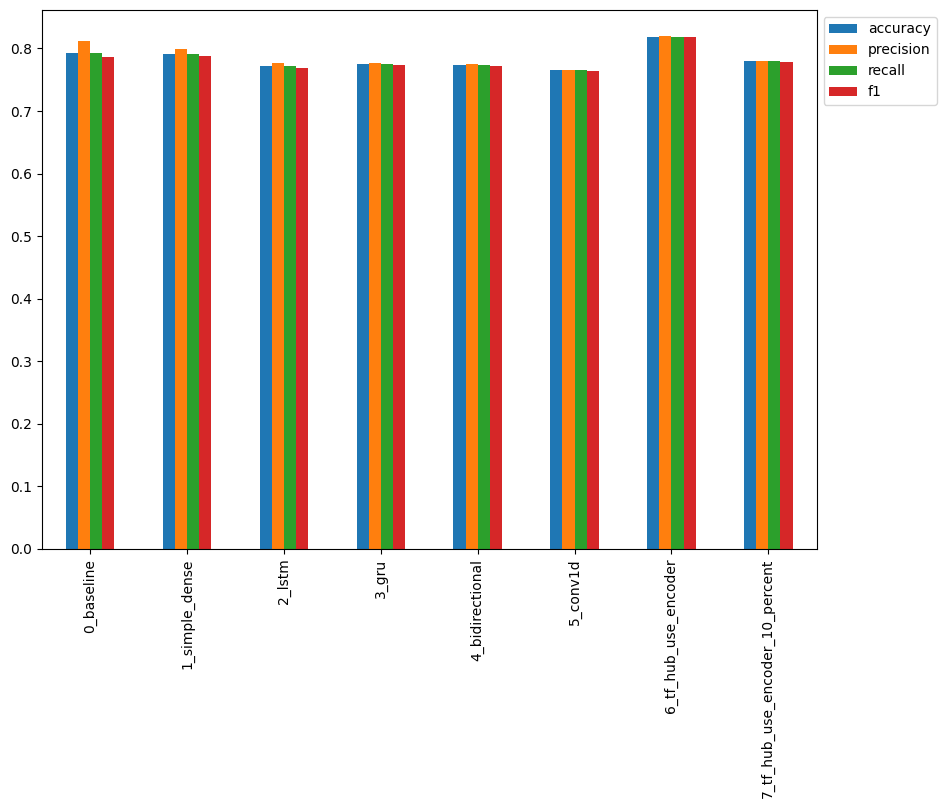

In [100]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

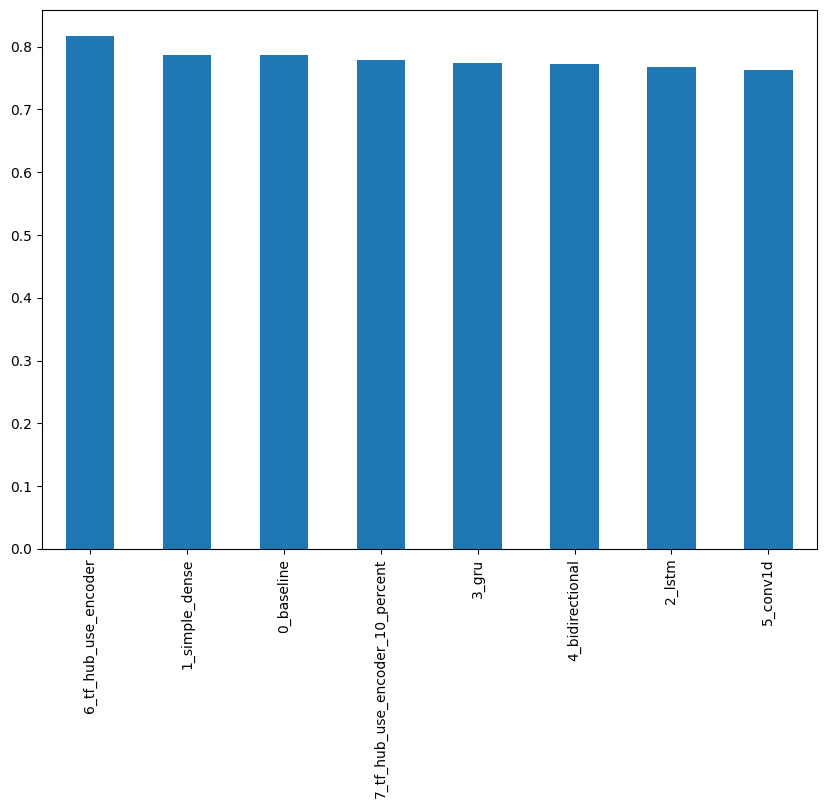

In [101]:
# Sort model results by f1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Uploading our model training logs to TensorBoard.dev

In [ ]:
# View Tensorboard logs of transfer learning modelling experiments (plus other models)
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments ZTM TF Course" \
  --description "Comparing multiple different types of model architectures on the Kaggle disaster dataset" \
  --one_shot # exit the uploader once uploading is finished

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (default when using tensorflow)

In [104]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6_.h5")

In [106]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6_.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [107]:
# How does our loaded model perform?
loaded_model_6.evaluate(X_val, y_val)

24/24 [==============================] - 1s 16ms/step - loss: 0.4245 - accuracy: 0.8189


[0.4245001971721649, 0.8188976645469666]

Now let's save to `SavedModel` format...

In [108]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [109]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [110]:
# Evaluatge model in savedmodel format
loaded_model_6_SavedModel_format.evaluate(X_val, y_val)

24/24 [==============================] - 1s 15ms/step - loss: 0.4245 - accuracy: 0.8189


[0.4245001971721649, 0.8188976645469666]

## Finding the most wrong examples
* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will predict probabilities closest to the opposite class)

For example if a sample should have a label of 0, bu our model predicts a prediction probability of 0.999 (really close to 1) and vice versa

In [111]:
# Download a pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-04-18 17:08:45--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   167MB/s    in 6.4s    

2023-04-18 17:08:52 (143 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [112]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(X_val, y_val)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [113]:
# Make predictions
model_6_pretrained_pred_probs = model_6_pretrained.predict(X_val)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 2s 23ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [114]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": X_val,
                       "target": y_val,
                       "pred": model_6_pretrained_preds,
                       "pred_probs": tf.squeeze(model_6_pretrained_pred_probs)})

val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [116]:
# Find the wrong predictions
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)

most_wrong.head() # false positives

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [117]:
most_wrong.tail() # false negatives

,text,target,pred,pred_probs
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [118]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

Target: 0, Pred: 1.0, Prob: 0.8108

In [119]:
# Check the false negatives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

Target: 1, Pred: 0.0, Prob: 0.042086850851774216
Text:
I get to s

In [121]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 55ms/step
Pred: 1, Prob: 0.772675096988678
Text:
The Murderous Story Of AmericaÛªs First Hijacking http://t.co/VgBOpxb6Wg

-----

1/1 [==============================] - 0s 36ms/step
Pred: 1, Prob: 0.8815591931343079
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/OFhjcn36o1

-----

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.9035035967826843
Text:
Cop pulls drunk driver to safety SECONDS before his car is hit by train. http://t.co/cTL5xzIHxAåÊ http://t.co/1kDOZTD9mv via @ViralSpell

-----

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.4771186113357544
Text:
@snapharmony : People are finally panicking about cable TV http://t.co/boUa80Z5Wf

-----

1/1 [==============================] - 0s 42ms/step
Pred: 0, Prob: 0.039510197937488556
Text:
Businesses are deluged with invoices. Make yours stand out with .olour or share and it's likely to rise to the top of the 

## The speed/score tradeoff

In [122]:
model_6_results

{'accuracy': 0.8188976377952756,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756,
 'f1': 0.8176416157404923}

In [123]:
# Let's make a function to measure the time of prediction
import time

def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [126]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                             samples=X_val)

model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 15ms/step


(0.771764222999991, 0.0010128139409448702)

In [128]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                             samples=X_val)

baseline_total_pred_time, baseline_time_per_pred

(0.05510964099994453, 7.232236351698758e-05)

In [129]:
model_6_pretrained_results = eval_metrics(y_true=y_val,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 0.8162729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

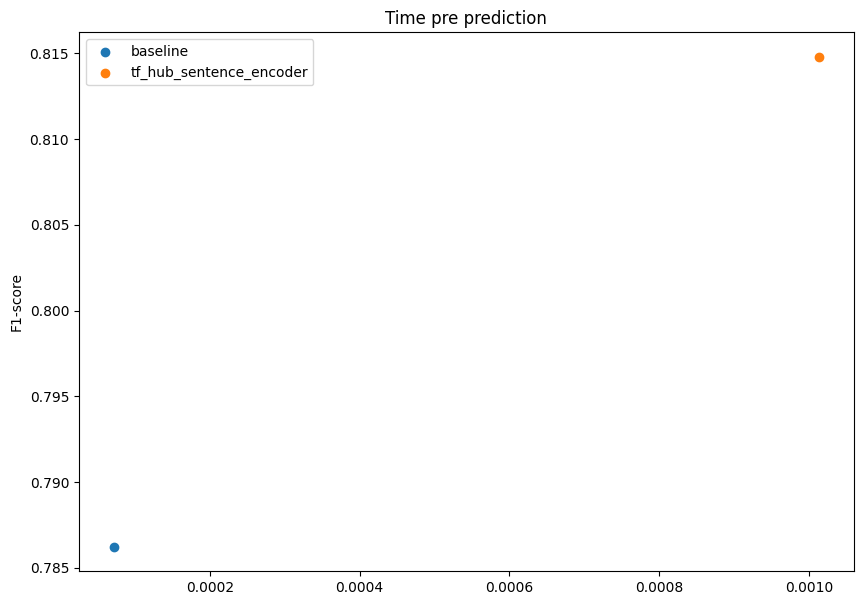

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time prediction")
plt.title("Time pre prediction")
plt.ylabel("F1-score");